## AttacKG result eval
- 主詞: 'type': 'executable'
- 受詞: rc.local /proc/self/exe https:// 61.147.91.53

In [1]:
import os
import sys
# Getting the path of the parent folder
# parent folder is 'c:\\Users\\luweb\\OneDrive\\文件\\GitHub\\2022-CCoE'
parent_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
parent_folder_path += "\\C sent nlp\\比較Dofloo各樣本的ST" 
# Adding the parent folder path to the system path
sys.path.append(parent_folder_path)
from cc_regex_script import RegexMaster, RegexMatchResult

In [7]:
import json
import networkx as nx
import glob
dot_path = "./results_AttacKG/Dofloo-SyscallParty_output.pdf.dot"
json_path = "./results_AttacKG/Dofloo-SyscallParty_output.pdf_artifacts.json"

def get_all_reportjsons() -> list[str]:
    folder_path = './results_AttacKG'
    blacklist = ['skip', 'exclude', 'SyscallParty_output']
    json_files = [f for f in glob.glob(f"{folder_path}/**/*.json", recursive=True) \
                  if not any(True if f.find(black)>=0 else False for black in blacklist)] # bug, doesn't works lol
    return json_files

def read_json(json_path: str) -> dict:
    ''' merge node data into a list '''
    with open(json_path, 'r', encoding='utf-8') as f:
        jsdata:dict = json.load(f)
    nodes_info: dict[str,list] = {}
    for nodeid, val in jsdata.items():
        nodes_info[nodeid] = {
            'type': val['type'],
            'data': sorted(val['nlp'] + val['ioc'])
        }
    del jsdata
    return nodes_info

def read_dot(dot_path: str) -> nx.Graph:
    G = nx.Graph(nx.nx_pydot.read_dot(dot_path))
    return G

def search(input_list: list[str]) -> str:
    '''easy search. return the first hit item''' #todo return all hit items
    target = ['rc.local', '/proc/self/exe', '61.147.91.53']
    for i in input_list:
        for t in target:
            if i.find(t) != -1:
                return t
            
# RegexMaster for searching
regexMaster = RegexMaster(familyname='Dofloo')
regex_pool = regexMaster.get_all_regex()

def search_with_regex(input_list: list[str]) -> set[RegexMatchResult]:
    '''return matched regex set'''
    findings = set()
    for strIn in input_list:
        regex_dst_node_list = RegexMaster.find_spacial_token_with_regex(regex_pool, strIn)
        if regex_dst_node_list is None or len(regex_dst_node_list) == 0:
            continue
        for regex_result in regex_dst_node_list:
            dst_node = regex_result # regex_result.match_regex
            findings.add(dst_node)
    if len(findings):
        return findings
    return None
            
def get_scrnode_from_dstnode(G: nx.Graph, nid: str) -> list:
    scr_lst = []
    for e in G.edges():
        if e[1] == nid:
            scr_lst.append(e[0])
    return scr_lst

- main codes

In [9]:
def main(dot_path, json_path):
    # read graph with only node id
    G = read_dot(dot_path)
    # for e in G.edges():
    #     print(e)

    # 計算node edge個數
    print(f"num of object-like items {len(G.nodes())}, num of dependencies {len(G.edges())}")

    # read node info for id
    nodes_info = read_json(json_path)

    # algorithm here
    hit_objs = set()
    print("\nContains actions:")
    for nid, n in nodes_info.items():
        # print(n)
        # res = search(n['data'])
        res_lst:set[RegexMatchResult] = search_with_regex(n['data'])
        if res_lst:
            for res in res_lst:
                hit_objs.add(res.match_regex)
                # print(res)
                scr_nid_lst = get_scrnode_from_dstnode(G, nid)
                for src_nid in scr_nid_lst:
                    scrnode = nodes_info[src_nid]
                    print(f"{scrnode} -> {res.word}")
    print(f"\nContains {len(hit_objs)} matched objects in report: \n{hit_objs}")

jsons = get_all_reportjsons()
for json_path in jsons:
    dot_path = json_path.replace('_artifacts.json', '.dot')
    reportname = json_path.split('\\')[-1].replace('.txt.pdf_artifacts.json', '')
    print(f'--\n{reportname}')
    main(dot_path, json_path)

--
Dofloo-BleepingComputer
num of object-like items 66, num of dependencies 49

Contains actions:

Contains 0 matched objects in report: 
set()
--
Dofloo-MalwareMustDie
num of object-like items 281, num of dependencies 150

Contains actions:
{'type': 'executable', 'data': ['executable']} -> 0x0002fc10
{'type': 'file', 'data': ['data:0x08c5c8', 'unk_0x08c5c4 <']} -> 182.254.180.241

Contains 2 matched objects in report: 
{'\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}', '0x[0-9a-zA-Z]{8}'}
--
Dofloo-Securityaffairs
num of object-like items 51, num of dependencies 39

Contains actions:
{'type': 'file', 'data': ['48080']} -> 23.224.59.34
{'type': 'executable', 'data': ['commands']} -> 23.224.59.34
{'type': 'file', 'data': ['algorithm', 'files']} -> /rc.local

Contains 2 matched objects in report: 
{'rc.local', '\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}\\.\\d{1,3}'}
--
Dofloo-SyscallParty
num of object-like items 191, num of dependencies 102

Contains actions:
{'type': 'file', 'data': ['file']} -> /rc.lo

In [8]:
jsons = get_all_reportjsons()
jsons

['./results_AttacKG\\Dofloo-BleepingComputer.txt.pdf_artifacts.json',
 './results_AttacKG\\Dofloo-MalwareMustDie.txt.pdf_artifacts.json',
 './results_AttacKG\\Dofloo-Securityaffairs.txt.pdf_artifacts.json',
 './results_AttacKG\\Dofloo-SyscallParty.txt.pdf_artifacts.json',
 './results_AttacKG\\Dofloo-Trendmicro.txt.pdf_artifacts.json',
 './results_AttacKG\\Xorddos-Cdnetworks.txt.pdf_artifacts.json',
 './results_AttacKG\\Xorddos-Crowdstrike.txt.pdf_artifacts.json',
 './results_AttacKG\\Xorddos-Intezer.txt.pdf_artifacts.json',
 './results_AttacKG\\Xorddos-MS.txt.pdf_artifacts.json',
 './results_AttacKG\\Xorddos-Trendmicro.txt.pdf_artifacts.json',
 './results_AttacKG\\Xorddos-Trendmicro2.txt.pdf_artifacts.json']

In [29]:
G.edges()

EdgeView([('14', '12'), ('12', '34'), ('34', '31'), ('31', '36'), ('44', '51'), ('51', '78'), ('78', '54'), ('54', '56'), ('176', '192'), ('192', '166'), ('166', '195'), ('195', '187'), ('187', '204'), ('204', '171'), ('171', '210'), ('230', '245'), ('245', '241'), ('280', '276'), ('299', '297'), ('307', '327'), ('327', '330'), ('330', '325'), ('338', '335'), ('335', '359'), ('359', '367'), ('425', '444'), ('548', '533'), ('550', '554'), ('559', '567'), ('592', '603'), ('603', '615'), ('619', '651'), ('677', '692'), ('692', '681'), ('730', '743'), ('822', '824'), ('870', '899'), ('899', '897'), ('897', '875'), ('875', '884'), ('913', '917'), ('917', '912'), ('912', '924'), ('939', '948'), ('948', '952'), ('952', '965'), ('1007', '986'), ('1017', '1023'), ('1064', '1072'), ('1105', '1100'), ('1100', '1115'), ('1115', '1111'), ('1124', '1123'), ('1164', '1152'), ('1152', '1181'), ('1181', '1173'), ('1173', '1153'), ('1153', '1161'), ('1255', '1261'), ('1293', '1278'), ('1278', '1280'), (

In [18]:
def get_scrnode_from_dstnode(G: nx.Graph, nid: str) -> list:
    scr_lst = []
    for e in G.edges():
        if e[1] == nid:
            scr_lst.append(e[0])
    return scr_lst

get_scrnode_from_dstnode(G, '1638')

['1617']

## Extractor result eval

In [ ]:
# import os
# import sys
# # Getting the path of the parent folder
# # parent folder is 'c:\\Users\\luweb\\OneDrive\\文件\\GitHub\\2022-CCoE'
# parent_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# parent_folder_path += "\\C sent nlp\\比較Dofloo各樣本的ST" 
# # Adding the parent folder path to the system path
# sys.path.append(parent_folder_path)
# from cc_regex_script import RegexMaster, RegexMatchResult

In [16]:
import json
import networkx as nx
import glob
dot_path = "./results_Extractor/Dofloo-SyscallParty.dot"
# dot_path = "./results_Extractor/Dofloo-SyscallParty_noElip.dot"
# dot_path = "./results_Extractor/Dofloo-SyscallParty_noAster.dot" # cannot read

# def get_all_reportjsons() -> list[str]:
#     folder_path = './results_AttacKG'
#     blacklist = ['skip', 'exclude', 'SyscallParty_output']
#     json_files = [f for f in glob.glob(f"{folder_path}/**/*.json", recursive=True) \
#                   if not any(True if f.find(black)>=0 else False for black in blacklist)] # bug, doesn't works lol
#     return json_files

def read_dot(dot_path: str) -> nx.Graph:
    G = nx.Graph(nx.nx_pydot.read_dot(dot_path))
    return G

G = read_dot(dot_path)

In [33]:
print(f"num of object-like items {len(G.nodes())}, num of dependencies {len(G.edges())}")

num of object-like items 25, num of dependencies 19


In [30]:
# data 可以多附加 attr 的字典，但字典的 key 不盡相同，跟隨著 .dot 檔內容
for n in G.nodes(data=True):
    print(n, type(n))
    break

("'*'", {'node_type': 'file', 'shape': 'ellipse'}) <class 'tuple'>


In [32]:
G.nodes(data=True)

NodeDataView({"'*'": {'node_type': 'file', 'shape': 'ellipse'}, '.*\\*': {'node_type': 'File', 'shape': 'ellipse'}, "'binary.ninja'": {'node_type': 'file', 'shape': 'ellipse'}, '.*\\binary.ninja': {'node_type': 'File', 'shape': 'ellipse'}, "'linux.die.net'": {'node_type': 'file', 'shape': 'ellipse'}, '.*\\linux.die.net': {'node_type': 'File', 'shape': 'ellipse'}, "'/-gnu-/'": {'node_type': 'file', 'shape': 'ellipse'}, "'/-four-/'": {'node_type': 'file', 'shape': 'ellipse'}, "'/-frame-/'": {'node_type': 'file', 'shape': 'ellipse'}, "'/-ps-/'": {'node_type': 'file', 'shape': 'ellipse'}, " IP '*'": {'node_type': 'file', 'shape': 'diamond'}, "'/-first-/'": {'node_type': 'file', 'shape': 'ellipse'}, '.*\\/-first-/': {'node_type': 'File', 'shape': 'ellipse'}, "'man7.org'": {'node_type': 'file', 'shape': 'ellipse'}, "'gethostbyname.3.htm'": {'node_type': 'file', 'shape': 'ellipse'}, '*': {}, 'binary.ninja': {}, 'linux.die.net': {}, '/-gnu-/': {}, '/-four-/': {}, '/-frame-/': {}, '/-ps-/': {},

In [31]:
G.edges(data=True)

EdgeDataView([("'*'", "'*'", {'label': '"285: \'read\'"'}), ("'*'", '.*\\*', {'label': '"262: exec"'}), ("'*'", "'binary.ninja'", {'label': '"26: fork"'}), ("'*'", '.*\\binary.ninja', {'label': '"26: exec"'}), ("'*'", "'linux.die.net'", {'label': '"28: fork"'}), ("'*'", '.*\\linux.die.net', {'label': '"28: exec"'}), ("'*'", "'/-first-/'", {'label': '"152: fork"'}), ("'*'", '.*\\/-first-/', {'label': '"152: exec"'}), ("'*'", " IP '*'", {'label': '"297: send"'}), ("'*'", "'/-gnu-/'", {'label': '"34: receive"'}), ('*', '*', {'label': '"298: command"'}), ('*', '/-gnu-/', {'label': '"36: link"'}), ('*', '/-four-/', {'label': '"56: \'s"'}), ('*', '/-frame-/', {'label': '"66: hold"'}), ('*', '/-ps-/', {'label': '"92: do"'}), ('*', '/-first-/', {'label': '"210: pass"'}), ('*', 'man7.org', {'label': '"208: be"'}), ('*', 'gethostbyname.3.htm', {'label': '"209: be"'}), ('binary.ninja', 'linux.die.net', {'label': '"31: ltrace"'})])

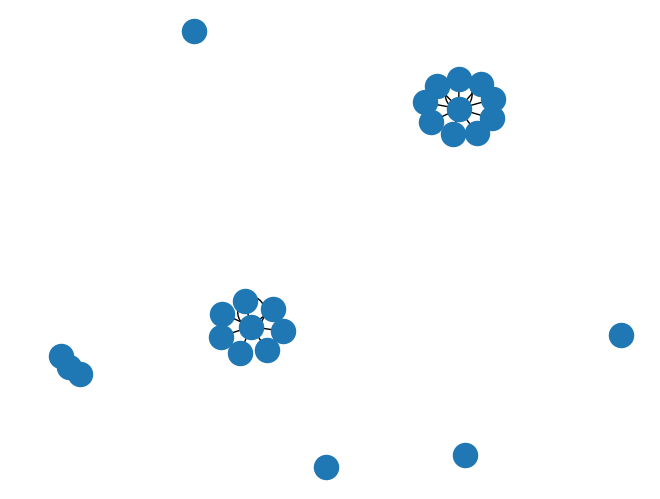

In [20]:
nx.draw(G)

In [23]:
# https://stackoverflow.com/questions/54439731/networkx-read-dot-does-not-inherit-attributes
import networkx as nx
import matplotlib.pyplot as plt
import ast

G
labels = {n[0] : ast.literal_eval(n[1]['node_type']) for n in G.nodes(data=True)}
nx.draw_networkx(G, with_labels=True, labels=labels)
plt.show()

ValueError: malformed node or string on line 1: <ast.Name object at 0x0000027A08A69DE0>

In [25]:
import networkx as nx

A = nx.drawing.nx_agraph.to_agraph(nx.drawing.nx_pydot.read_dot(dot_path))
A.layout('dot')
A.draw('tree.png')

ImportError: requires pygraphviz http://pygraphviz.github.io/

In [26]:
! pip install pygraphviz --use-pep517

  Using cached pygraphviz-1.10.zip (120 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pygraphviz


  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\agraph.py -> build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\graphviz.py -> build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\scraper.py -> build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\testing.py -> build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\__init__.py -> build\lib.win-amd64-cpython-310\pygraphviz
      creating build\lib.win-amd64-cpython-310\pygraphviz\tests
      copying pygraphviz\tests\test_attribute_defaults.py -> build\lib.win-amd64-cpython-310\pygraphviz\tests
      copying pygraphviz\tests\test_clear.py -> build\lib.